# Problem 3a

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib.pyplot as plt

import scipy.special as special
df = np.loadtxt("/Users/benjaminlim/Documents/BootCamp2017/Labs/Econ/Week 4/usincmoms.txt")

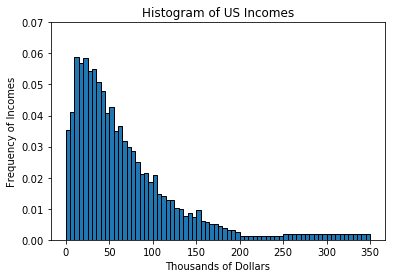

In [2]:
pctlast = df[-2,0]/10
pctseclast = df[-1,0]/20
graph = df[:-2,]
replace = np.zeros((30,2)) #create vec for last two bins
replace[:10,0] = pctseclast
replace[10:, 0] = pctlast
replace[:10, 1] = np.linspace(202500, 247500, 10) #dollars vec for second last bin
replace[10:, 1] = np.linspace(252500, 347500, 20) #dollars vec for last bin
graph = np.concatenate((graph, replace), axis = 0) #concat last two bins to rest of the bins
graph[:,1] = graph[:,1]/1000
width = 5
plt.bar(graph[:,1], graph[:,0], width = width, edgecolor ="k")
plt.ylim((0,0.07))
plt.xlabel("Thousands of Dollars")
plt.ylabel("Frequency of Incomes")
plt.title("Histogram of US Incomes")
plt.show()

# Problem 3b

In [3]:
pct = df[:,0]
mps = df[:,1]/1000
def lognorm_cdf(xvals, mu, sigma):
    
    cdf_vals = sts.lognorm.cdf(xvals, s = sigma, scale = mu)
        
    return cdf_vals


def data_moments(pct):
    
    return pct

def model_moments(mps, mu, sigma):

    modelmom = np.zeros((42,1))
    modelmom[0] = lognorm_cdf(mps[0]+2.5, mu, sigma)
    
    for i in range(0, 39):
        modelmom[i+1] = lognorm_cdf(mps[i+1]+2.5, mu, sigma) - lognorm_cdf(mps[i]+2.5, mu, sigma) 
    
    modelmom[40] = lognorm_cdf(mps[40], mu, sigma) - lognorm_cdf(mps[39]+2.5, mu, sigma)
    modelmom[41] = lognorm_cdf(np.inf, mu, sigma) - lognorm_cdf(mps[40], mu, sigma)
    
    return modelmom

def err_vec(pct, mps, mu, sigma, simple):

    datamom = data_moments(pct).reshape(42,1)
    modelmom = model_moments(mps, mu, sigma)

    if simple:
        err_vec = modelmom - datamom
    else:
        err_vec = (modelmom - datamom) / datamom
    return err_vec

def criterion(params, *args):

    mu, sigma = params
    pct, mps, W = args
    err = err_vec(pct, mps, mu, sigma, simple = False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [4]:
mu_init = (graph[:, 0]*graph[:,1]).sum()
sig_init = 100
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(pct)
gmm_args = (pct, mps, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

print(results)

mu_GMM1= 46.9696678206  sig_GMM1= 0.885205270117
      fun: array([[ 0.05764129]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.93889390e-09,   1.43635104e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 141
      nit: 19
   status: 0
  success: True
        x: array([ 46.96966782,   0.88520527])


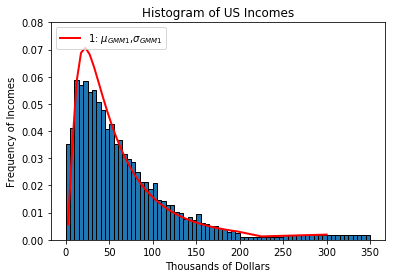

[[ 0.05764129]]


In [5]:
# Plot the estimated GMM PDF

def lognorm_dist(xvals, mu, sigma):
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))))
    pdf_vals[np.isclose(pdf_vals, np.zeros_like(pdf_vals), atol = 1e-25)] = 1e-24
    
    return pdf_vals

mpsmom1 = model_moments(mps, mu_GMM1, sig_GMM1)
mpsmom1[40] = mpsmom1[40]/10
mpsmom1[41] = mpsmom1[41]/20
plt.plot(mps, mpsmom1,
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')
plt.bar(graph[:,1], graph[:,0], width = width, edgecolor ="k")
plt.ylim((0,0.08))
plt.xlabel("Thousands of Dollars")
plt.ylabel("Frequency of Incomes")
plt.title("Histogram of US Incomes")
plt.show()

params_ln1 = np.array([mu_GMM1, sig_GMM1])
print(criterion(params_ln1, pct, mps, W_hat))

# Problem 3c

In [6]:
import scipy.stats as sts
def gamma_cdf(xvals, alpha, beta):
    
    cdf_vals = sts.gamma.cdf(xvals, a = alpha, scale = beta)
        
    return cdf_vals

def model_moments_ga(mps, alpha, beta):
    
    modelmom = np.zeros((42,1))
    modelmom[0] = gamma_cdf(mps[0]+2.5, alpha, beta)
    
    for i in range(0, 39):
        modelmom[i+1] = gamma_cdf(mps[i+1]+2.5, alpha, beta) - gamma_cdf(mps[i]+2.5, alpha, beta)
    
    modelmom[40] = gamma_cdf(mps[40], alpha, beta) - gamma_cdf(mps[39]+2.5, alpha, beta)
    modelmom[41] = gamma_cdf(np.inf, alpha, beta) - gamma_cdf(mps[40], alpha, beta)
    
    return modelmom

def err_vec_ga(pct, mps, alpha, beta, simple):

    datamom = data_moments(pct).reshape(42,1)
    modelmom = model_moments_ga(mps, alpha, beta)

    if simple:
        err_vec = modelmom - datamom
    else:
        err_vec = (modelmom - datamom) / datamom
    return err_vec

def criterion_ga(params, *args):

    alpha, beta = params
    pct, mps, W = args
    err = err_vec_ga(pct, mps, alpha, beta, simple = False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

alpha_init = 3
beta_init = 20
params_init = np.array([alpha_init, beta_init])
W_hat = np.diag(pct)
gmm_args_ga = (pct, mps, W_hat)
results = opt.minimize(criterion_ga, params_init, args=(gmm_args_ga),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)

print(results)

alpha_GMM1= 1.36919941935  beta_GMM1= 48.0990141151
      fun: array([[ 0.00990058]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.65440578e-06,  -9.14199272e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 14
   status: 0
  success: True
        x: array([  1.36919942,  48.09901412])


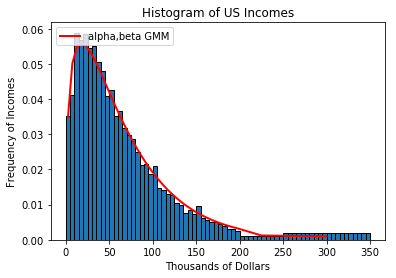

[[ 0.00990058]]


In [7]:
from scipy import special
mpsmom2 = model_moments_ga(mps, alpha_GMM1, beta_GMM1)
mpsmom2[40] = mpsmom2[40]/10
mpsmom2[41] = mpsmom2[41]/20
plt.plot(mps, mpsmom2,
         linewidth=2, color='r',label='alpha,beta GMM')

plt.legend(loc='upper left')
plt.bar(graph[:,1], graph[:,0], width = width, edgecolor ="k")
plt.xlabel("Thousands of Dollars")
plt.ylabel("Frequency of Incomes")
plt.title("Histogram of US Incomes")
plt.show()
params_ga1 = np.array([alpha_GMM1, beta_GMM1])

print(criterion_ga(params_ga1, pct, mps, W_hat))

# Problem 3d

Looking at the plot, the Gamma distribution fits the best. It also has a much lower criterion function value.

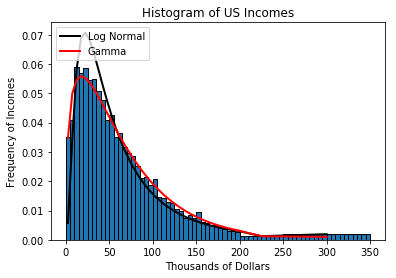

In [8]:
mpsmom1 = model_moments(mps, mu_GMM1, sig_GMM1)
mpsmom1[40] = mpsmom1[40]/10
mpsmom1[41] = mpsmom1[41]/20
plt.plot(mps, mpsmom1,
         linewidth=2, color='k', label='Log Normal')
mpsmom2 = model_moments_ga(mps, alpha_GMM1, beta_GMM1)
mpsmom2[40] = mpsmom2[40]/10
mpsmom2[41] = mpsmom2[41]/20
plt.plot(mps, mpsmom2,
         linewidth=2, color='r',label='Gamma')
plt.bar(graph[:,1], graph[:,0], width = width, edgecolor ="k")
plt.xlabel("Thousands of Dollars")
plt.ylabel("Frequency of Incomes")
plt.title("Histogram of US Incomes")
plt.legend(loc='upper left')

plt.show()

# Problem 3e

The criterion function value using the identity weighting matrix was 0.0099, while that using the two-step weighting matrix was 0.05. As such, going by the criterion function, the identity weighting matrix seems to have a better fit. Looking at the plots, it also seems that the distribution estimated using the one-step matrix fits the incomes below $200,000 better, while that of the two-step matrix has a better fit in the right tail of the distribution. The estimates for alpha and beta do not change much.

In [13]:
errvec = err_vec_ga(pct, mps, alpha_GMM1, beta_GMM1, False)
omega = (1/len(errvec))*np.outer(errvec,errvec)
W_hat_2 = np.linalg.inv(omega)

alpha_init = alpha_GMM1
beta_init = beta_GMM1
params_init = np.array([alpha_init, beta_init])
gmm_args_ga = (pct, mps, W_hat_2)
results = opt.minimize(criterion_ga, params_init, args=(gmm_args_ga),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_2, beta_GMM_2 = results.x
print('alpha_GMM_2=', alpha_GMM_2, ' beta_GMM_2=', beta_GMM_2)

print(results)
params_ga2 = np.array([alpha_GMM_2, beta_GMM_2])
print(criterion_ga(params_ga2, pct, mps, W_hat))

alpha_GMM_2= 1.58219077634  beta_GMM_2= 48.0990141151
      fun: array([[ -3.31880819e+19]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.38803200e+14,   1.63570319e+19])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 2
   status: 0
  success: True
        x: array([  1.58219078,  48.09901412])
[[ 0.05132132]]


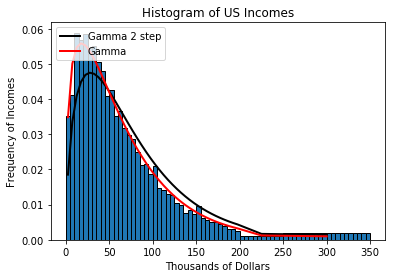

In [17]:
mpsmom3 = model_moments_ga(mps, alpha_GMM_2, beta_GMM_2)
mpsmom3[40] = mpsmom3[40]/10
mpsmom3[41] = mpsmom3[41]/20
plt.plot(mps, mpsmom3,
         linewidth=2, color='k', label='Gamma 2 step')
mpsmom2 = model_moments_ga(mps, alpha_GMM1, beta_GMM1)
mpsmom2[40] = mpsmom2[40]/10
mpsmom2[41] = mpsmom2[41]/20
plt.plot(mps, mpsmom2,
         linewidth=2, color='r',label='Gamma')
plt.bar(graph[:,1], graph[:,0], width = width, edgecolor ="k")
plt.xlabel("Thousands of Dollars")
plt.ylabel("Frequency of Incomes")
plt.title("Histogram of US Incomes")
plt.legend(loc='upper left')

plt.show()